# Setup/Imports

In [3]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
from utils.callbacks import CyclicLR, TensorBoardWrapper
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt

from helpers.normalization import normalize, denormalize, renormalize
# import tkinter as tk
# from tkinter import filedialog
# root = tk.Tk()
# root.withdraw()

In [4]:
num_cores = 4
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                        inter_op_parallelism_threads=num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [5]:
%matplotlib inline
font={'family': 'Times New Roman',
      'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

# Functions

In [66]:
def hinge_loss(delta_true, delta_pred):
    """Finds the percentage of the time the prediction has the right sign
    """
    return np.sum(np.maximum(np.sign(delta_true*delta_pred),0))/delta_true.size

def batch_hinge(model,generator,param_dict,sig):
    """Finds the percentage of the time the prediction has the right sign
    """    
    nbatches = len(generator)
    err = 0
    for ind in range(nbatches):
        inputs, targets = generator[ind]
        predictions = model.predict_on_batch(inputs)
        full_pred, full_true, delta_pred, delta_true, baseline = batch_denorm(inputs,targets,predictions,param_dict,sig)
        err += hinge_loss(delta_true,delta_pred)
    return err/nbatches    

def batch_denorm(inputs,targets,predictions,param_dict,sig):
    """Denormalizes and calculates deltas, prep for plotting and analysis
    """
    targets = targets['target_' + sig]
    baseline = inputs['input_' + sig][:,-1]
    predictions = predictions[sig]
    if predict_deltas:
        full_pred = predictions + baseline
        full_true = targets + baseline
    else:
        full_pred = predictions
        full_true = targets
    denorm_baseline = denormalize(baseline, param_dict[sig])
    denorm_full_pred = denormalize(full_pred, param_dict[sig])
    denorm_full_true = denormalize(full_true, param_dict[sig])
    denorm_delta_pred = denorm_full_pred - denorm_baseline
    denorm_delta_true = denorm_full_true - denorm_baseline
    return denorm_full_pred, denorm_full_true, denorm_delta_pred, denorm_delta_true, denorm_baseline

def plot_batch(y_true, y_pred, baseline, psi, labels, axlabels,shots,times, y_modified = None):

    
    batch_size = y_true.shape[0]
    ncols = 4
    nrows = int(batch_size/ncols)
    figsize = (20,10*batch_size/10)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()
    # Plot predictions and true deltas
    for i in range(batch_size):
        ax[i].plot(psi,y_true[i], label=labels[0])
        ax[i].plot(psi,y_pred[i], label=labels[1])
        ax[i].plot(psi,baseline[i], label=labels[2])
        if y_modified is not None:
            ax[i].plot(psi, y_modified[i], label = labels[3])
        ax[i].title.set_text('Shot ' + str(int(shots[i])) + ', time ' + str(int(times[i])))
        ax[i].set_xlabel(axlabels[0])
        ax[i].set_ylabel(axlabels[1])
        ax[i].set_ylim(-2*normalization_params[sig]['std'],2*normalization_params[sig]['std'])
        ax[i].legend(loc=0)
    plt.tight_layout()
    return fig,ax

# Analysis

In [7]:
# file_path = filedialog.askopenfilename(title='Saved Model File',filetypes = [("hdf5 files","*.h5"),("all files","*.*")])
file_path = "/global/u2/a/al34/run_results/model-conv2d_profiles-temp-dens-rotation-ffprime_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-8_norm-StandardScaler_activ-relu_nshots-1000_01Aug19-10-10.h5"
model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + 'params.pkl'
with open(file_path, 'rb') as f:
     analysis_params = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(analysis_params.keys()))
locals().update(analysis_params)

Instructions for updating:
Colocations handled automatically by placer.
loaded model: model-conv2d_profiles-temp-dens-rotation-ffprime_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-8_norm-StandardScaler_activ-relu_nshots-1000_01Aug19-10-10.h5
loaded dict: model-conv2d_profiles-temp-dens-rotation-ffprime_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-8_norm-StandardScaler_activ-relu_nshots-1000_01Aug19-10-10params.pkl
with parameters: dict_keys(['rawdata', 'model_type', 'input_profile_names', 'actuator_names', 'target_profile_names', 'sig_names', 'predict_deltas', 'profile_lookback', 'actuator_lookback', 'lookahead', 'profile_length', 'profile_downsample', 'std_activation', 'window_length', 'window_overlap', 'sample_step', 'normalization_method', 'uniform_normalization', 'normalization_params', 'train_frac', 'val_frac', 'nshots', 'mse_weight_vector', 'hinge_weight', 'batch_size', 'epochs', 'runname', 'model_path', 'history', 'history_params'])


In [8]:
lookbacks = {'temp': profile_lookback,
             'dens': profile_lookback,
             'rotation': profile_lookback,
             'press': profile_lookback,
             'itemp': profile_lookback,
             'ffprime': profile_lookback,
             'pinj': actuator_lookback,
             'curr': actuator_lookback,
             'tinj': actuator_lookback,
             'gasA': actuator_lookback}

In [9]:
train_frac = 1
val_frac = 0
nshots = 1000
traindata, valdata, param_dict = process_data(rawdata, sig_names, normalization_method,
                                              window_length, window_overlap, lookbacks,
                                              lookahead, sample_step, uniform_normalization,
                                              train_frac, val_frac, nshots,verbose=1)
traindata = denormalize(traindata, param_dict)
traindata = renormalize(traindata, normalization_params)

Loading
Signals: curr, dens, ffprime, gasA, pinj, rotation, temp, tinj


Gathering:   1%|1         | 10/1000 [00:00<00:10, 96.71it/s]

Number of useable shots:  9581
Number of shots used:  1000
Total number of timesteps:  108430


Stacking:   0%|          | 0/10 [00:00<?, ?it/s]

Shots with Complete NaN: [157370.], [159015.], [161543.]


Normalizing:  20%|##        | 2/10 [00:00<00:00, 18.71it/s]

Total number of samples:  29714
Number of training samples:  29714
Number of validation samples:  0


Normalizing: 100%|##########| 10/10 [00:00<00:00, 23.60it/s]


In [98]:
batch_size = 16
train_generator = DataGenerator(traindata, batch_size, input_profile_names,
                                actuator_names, target_profile_names,
                                lookbacks, lookahead,
                                predict_deltas,2)
steps_per_epoch = len(train_generator)

In [99]:
batch_ind = np.random.randint(len(train_generator))
inputs, targets = train_generator[batch_ind]
shotnums = train_generator.cur_shotnum[:,max(profile_lookback, actuator_lookback)]
times = train_generator.cur_times[:,max(profile_lookback, actuator_lookback)]

In [100]:

pred = model.predict_on_batch(inputs)

predictions = {}
for i, sig in enumerate(target_profile_names):
    predictions[sig] = pred[i]
psi = np.linspace(0,1,profile_length)
full_pred = {}
full_true = {}
delta_pred = {}
delta_true = {}
baseline = {}
for sig in target_profile_names:
    full_pred[sig], full_true[sig], delta_pred[sig], delta_true[sig], baseline[sig] = batch_denorm(inputs,targets,predictions,
                                                                                                   normalization_params,sig)

In [106]:
inputs.keys()
actuator_names

['pinj', 'curr', 'tinj', 'gasA']

In [ ]:
['pinj', 'curr', 'tinj', 'gasA']

In [ ]:
import copy

In [258]:
# modify input accordingly for RANDOM NOISE WORK

modified_inputs = copy.deepcopy(inputs)
mu = 0 
sigma = 1

# sigs_to_change = actuator_names
sigs_to_change = ['gasA']
for sig in sigs_to_change:
#     modified_inputs["input_past_" + sig] = np.random.normal(mu, sigma, modified_inputs["input_past_" + sig].shape)
    modified_inputs["input_future_" + sig] = np.random.normal(mu, sigma, modified_inputs["input_future_" + sig].shape)

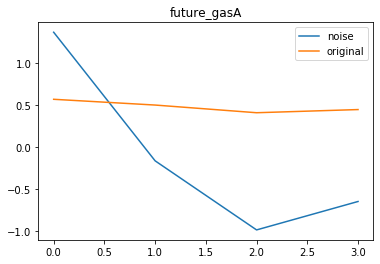

In [260]:
# sanity check
sig = "future_gasA"
index = 3
plt.plot(modified_inputs["input_" + sig][index], label = "noise")
plt.plot(inputs["input_" + sig][index], label = "original")
plt.title(sig)
plt.legend(loc = "best")

In [261]:
# noise predictions
modified_pred = model.predict_on_batch(modified_inputs)

modified_predictions = {}
for i, sig in enumerate(target_profile_names):
    modified_predictions[sig] = modified_pred[i]
    

modified_full_pred = {}
modified_full_true = {}
modified_delta_pred = {}
modified_delta_true = {}
modified_baseline = {}
for sig in target_profile_names:
    modified_full_pred[sig], modified_full_true[sig], modified_delta_pred[sig], modified_delta_true[sig], modified_baseline[sig] = batch_denorm(modified_inputs,targets,modified_predictions,
                                                                                                   normalization_params,sig)

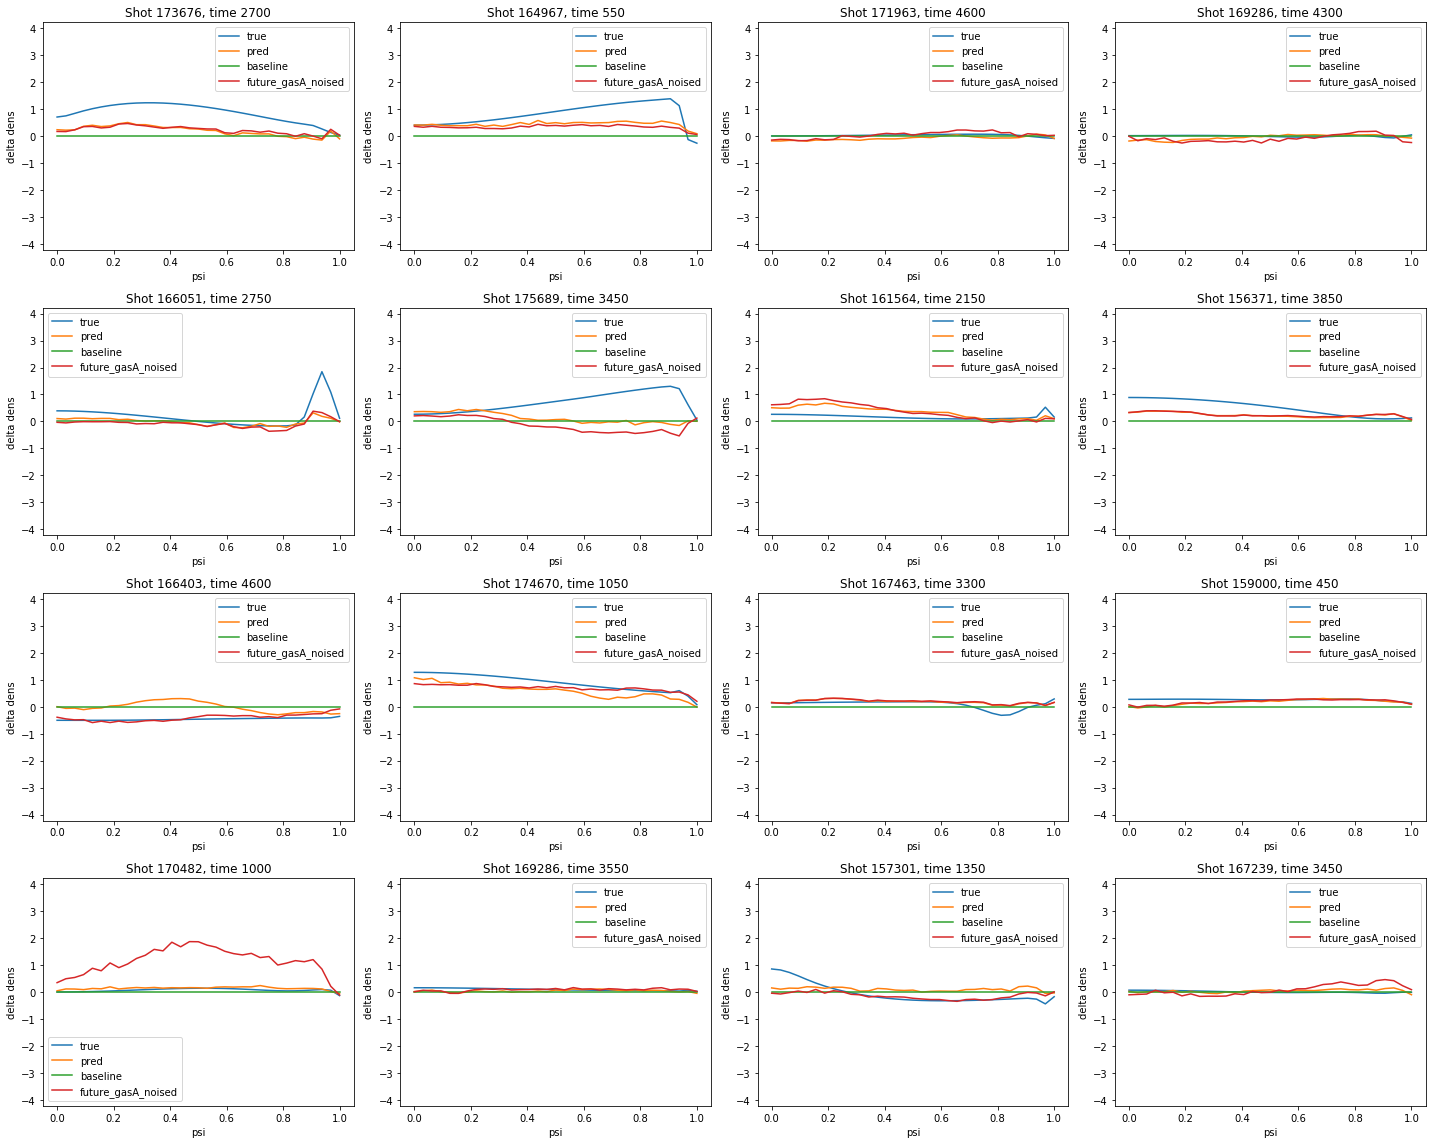

In [262]:
sig = 'dens'
fig, ax = plot_batch(delta_true[sig],delta_pred[sig],np.zeros_like(delta_true[sig]),
                     psi,['true','pred','baseline', 'future_gasA_noised'],['psi','delta ' + sig], shotnums,times, y_modified=modified_delta_pred[sig])  

In [ ]:
['pinj', 'curr', 'tinj', 'gasA']

In [ ]:
# KNOB WORK

In [217]:
# modify input accordingly for KNOB CHANGING work
knob_changes = [1,-1, 3, -3]
sig_to_change = "gasA"
diff_knob_inputs = {}
for change in knob_changes:
    
    
    modified_inputs = copy.deepcopy(inputs)
    #modified_inputs["input_past_" + sig] = np.random.normal(mu, sigma, modified_inputs["input_past_" + sig].shape)
    modified_inputs["input_future_" + sig_to_change] += change
    diff_knob_inputs[change] = modified_inputs

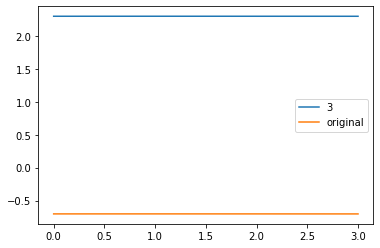

In [219]:
knob_amount = 3
sig = "gasA"
plt.plot(diff_knob_inputs[knob_amount]["input_future_" + sig][0], label = str(knob_amount))
plt.plot(inputs["input_future_"+sig][0], label = "original")
plt.legend(loc = "best")

In [220]:
# predicting for knob changes
diff_knob_results = {}


for knob in diff_knob_inputs.keys():
    
    modified_inputs = diff_knob_inputs[knob]

    modified_pred = model.predict_on_batch(modified_inputs)

    modified_predictions = {}
    for i, sig in enumerate(target_profile_names):
        modified_predictions[sig] = modified_pred[i]


    modified_full_pred = {}
    modified_full_true = {}
    modified_delta_pred = {}
    modified_delta_true = {}
    modified_baseline = {}
    for sig in target_profile_names:
        modified_full_pred[sig], modified_full_true[sig], modified_delta_pred[sig], modified_delta_true[sig], modified_baseline[sig] = batch_denorm(modified_inputs,targets,modified_predictions,
                                                                                                       normalization_params,sig)
    diff_knob_results[knob] = {}
    diff_knob_results[knob]['modified_full_pred'] = modified_full_pred
    diff_knob_results[knob]['modified_full_true'] = modified_full_true
    diff_knob_results[knob]['modified_delta_pred'] = modified_delta_pred
    diff_knob_results[knob]['modified_delta_true'] = modified_delta_true
    diff_knob_results[knob]['modified_baseline'] = modified_baseline
    
    

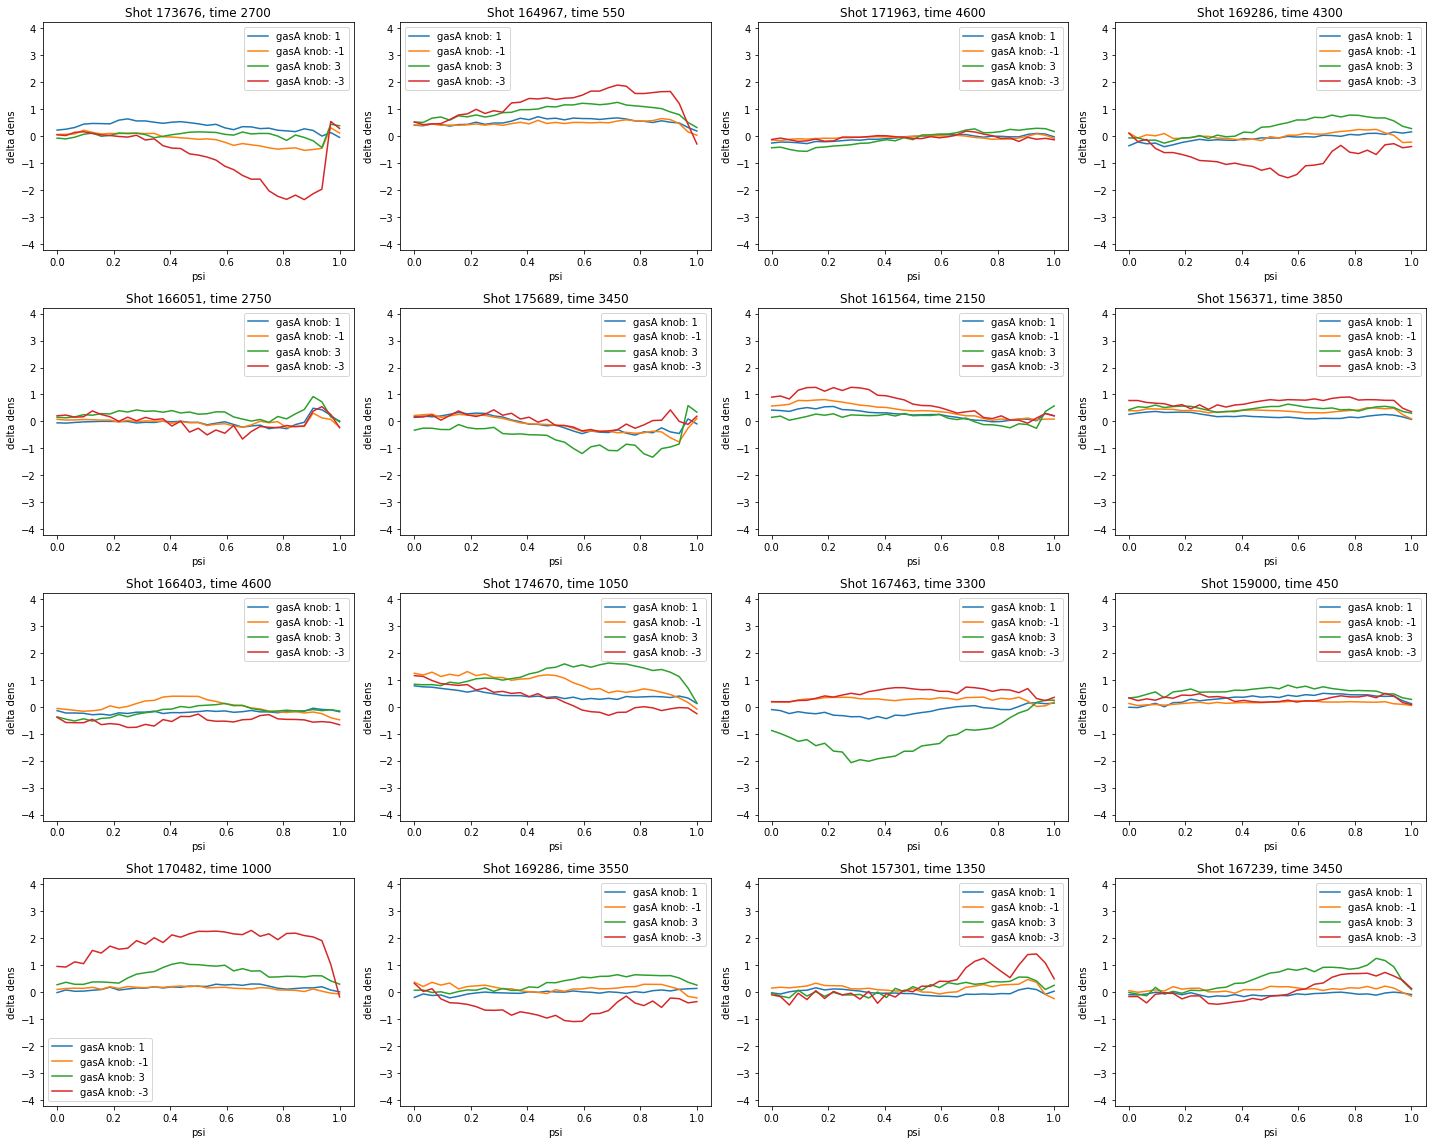

In [225]:
sig = 'dens'
y_mod_dict = {}
for knob in diff_knob_results.keys():
    y_mod_dict[knob] = diff_knob_results[knob]['modified_delta_pred'][sig]

fig, ax = plot_batch_knob(delta_true[sig],delta_pred[sig],np.zeros_like(delta_true[sig]),
                     psi,['true','pred','baseline', 'gasA'],['psi','delta ' + sig], shotnums,times, False, y_modified_dict=y_mod_dict)  


In [201]:
def plot_batch_knob(y_true, y_pred, baseline, psi, labels, axlabels,shots,times, comb, y_modified_dict = None):

    
    batch_size = y_true.shape[0]
    ncols = 4
    nrows = int(batch_size/ncols)
    figsize = (20,10*batch_size/10)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()
    # Plot predictions and true deltas
    for i in range(batch_size):
        if comb:
            
            ax[i].plot(psi,y_true[i], label=labels[0])
            ax[i].plot(psi,y_pred[i], label=labels[1])
            ax[i].plot(psi,baseline[i], label=labels[2])
        if y_modified_dict is not None:
            for knob in y_modified_dict.keys():
                ax[i].plot(psi, y_modified_dict[knob][i], label = labels[3] + " knob: " + str(knob))
                
        ax[i].title.set_text('Shot ' + str(int(shots[i])) + ', time ' + str(int(times[i])))
        ax[i].set_xlabel(axlabels[0])
        ax[i].set_ylabel(axlabels[1])
        ax[i].set_ylim(-2*normalization_params[sig]['std'],2*normalization_params[sig]['std'])
        ax[i].legend(loc=0)
    plt.tight_layout()
    return fig,ax

array([-0.57660496, -0.7392897 , -0.77849209, -0.85257738, -0.89342475,
       -0.93913721, -1.0136511 , -0.97525069, -1.02775878, -0.994194  ,
       -0.9648256 , -0.8570662 , -0.81708264, -0.67368812, -0.60738201,
       -0.54088761, -0.46962661, -0.44997056, -0.39371699, -0.38127889,
       -0.34331629, -0.33930859, -0.36037537, -0.33224633, -0.34576893,
       -0.30630841, -0.31540638, -0.30469858, -0.30200057, -0.32564406,
       -0.28787994, -0.13780256, -0.1045341 ])

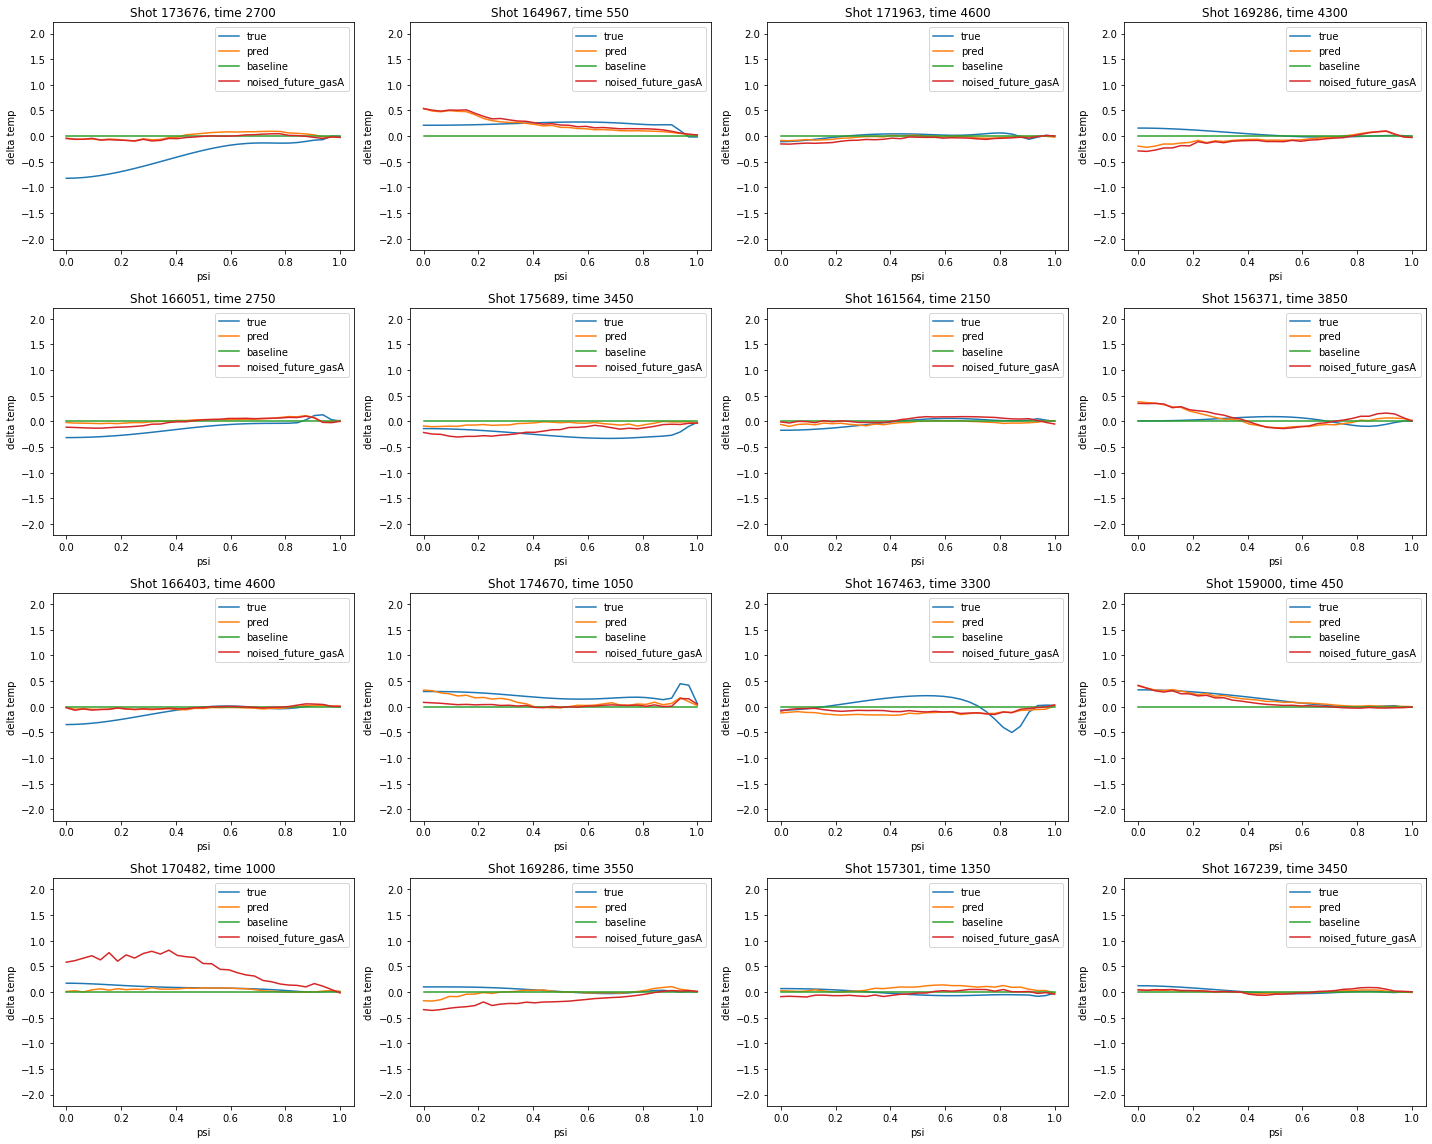

In [ ]:
sig = 'dens'
fig, ax = plot_batch(delta_true[sig],delta_pred[sig],np.zeros_like(delta_true[sig]),
                     psi,['true','pred','baseline'],['psi','delta ' + sig], shotnums,times)  

In [ ]:
sig = 'press'
fig, ax = plot_batch(delta_true[sig],delta_pred[sig],np.zeros_like(delta_true[sig]),
                     psi,['true','pred','baseline'],['psi','delta ' + sig], shotnums,times)  

In [ ]:
sig = 'temp'
fig, ax = plot_batch(full_true[sig],full_pred[sig],baseline[sig],
                     psi,['true','pred','baseline'],['psi',sig], shotnums,times)  

In [ ]:
sig = 'dens'
fig, ax = plot_batch(full_true[sig],full_pred[sig],baseline[sig],
                     psi,['true','pred','baseline'],['psi',sig], shotnums,times)  

In [ ]:
sig = 'press'
fig, ax = plot_batch(full_true[sig],full_pred[sig],baseline[sig],
                     psi,['true','pred','baseline'],['psi',sig], shotnums,times)  

In [ ]:
with open(rawdata,'rb') as f:
    data = pickle.load(f, encoding='latin1')

In [ ]:
sig = 'rotation'
zrat = []
for shot in data.values():
    if sig in shot.keys():
        if shot[sig].size>0:
            zrat.append(np.count_nonzero(shot[sig])/shot[sig].size)

In [ ]:
data[164334].keys()